**RetailCLV Predictor**

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [55]:
df = pd.read_csv("online_retail.csv", encoding='latin1')

In [56]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


**Data Cleaning and Preprocessing**

In [57]:
df.columns = df.columns.str.strip().str.replace(' ', '_')


In [58]:
df = df.dropna(subset=['Customer_ID'])


In [59]:
df['Customer_ID'] = df['Customer_ID'].astype(int)


<ipython-input-59-d858b3d43602>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer_ID'] = df['Customer_ID'].astype(int)


In [60]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

<ipython-input-60-d835c507c4e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)


In [61]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]


In [62]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


In [63]:
df['TotalAmount'] = df['Quantity'] * df['Price']


In [64]:
print("✅ Cleaned data shape:", df.shape)
df.head()

✅ Cleaned data shape: (397885, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


**Feature Engineering**

In [65]:
# Snapshot date = 1 day after the latest purchase in data
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [66]:
# Group by customer
customer_df = df.groupby('Customer_ID').agg({
    'InvoiceDate': [lambda x: (snapshot_date - x.max()).days,
                    lambda x: (x.max() - x.min()).days],
    'Invoice': 'nunique',
    'TotalAmount': 'sum',
    'Quantity': 'sum'
})

customer_df.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary', 'TotalQuantity']
customer_df = customer_df.reset_index()

customer_df['AvgOrderValue'] = customer_df['Monetary'] / customer_df['Frequency']
customer_df['AvgItemsPerOrder'] = customer_df['TotalQuantity'] / customer_df['Frequency']
customer_df['CLV'] = customer_df['Monetary']

In [67]:
customer_df['CLV'] = customer_df['Monetary']

In [68]:
print("Feature DataFrame shape:", customer_df.shape)
customer_df.head()

Feature DataFrame shape: (4338, 9)


,Customer_ID,Recency,Tenure,Frequency,Monetary,TotalQuantity,AvgOrderValue,AvgItemsPerOrder,CLV
0,12346,326,0,1,77183.60,74215,77183.600000,74215.000000,77183.60
1,12347,2,365,7,4310.00,2458,615.714286,351.142857,4310.00
2,12348,75,282,4,1797.24,2341,449.310000,585.250000,1797.24
3,12349,19,0,1,1757.55,631,1757.550000,631.000000,1757.55
4,12350,310,0,1,334.40,197,334.400000,197.000000,334.40


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from xgboost import XGBRegressor


**Prepare Features and Target**

In [70]:
X = customer_df[['Recency', 'Tenure', 'Frequency', 'TotalQuantity', 'AvgOrderValue', 'AvgItemsPerOrder']]

y = np.log1p(customer_df['CLV'])  # log(1 + CLV)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Train Baseline Model (Linear Regression)**

In [71]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🔹 Linear Regression R² Score: {r2}")
print(f"🔹 Linear Regression RMSE: {rmse}")


🔹 Linear Regression R² Score: 0.6303969150998698
🔹 Linear Regression RMSE: 0.7697692882841012


**Train Random Forest Regressor (Better Accuracy)**

In [72]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict (remember to inverse log!)
y_pred = np.expm1(xgb_model.predict(X_test))
y_true = np.expm1(y_test)

# Evaluate
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"🔥 XGBoost R² Score: {r2}")
print(f"🔥 XGBoost RMSE: {rmse}")


🔥 XGBoost R² Score: 0.8623486502833081
🔥 XGBoost RMSE: 3755.1822964713124


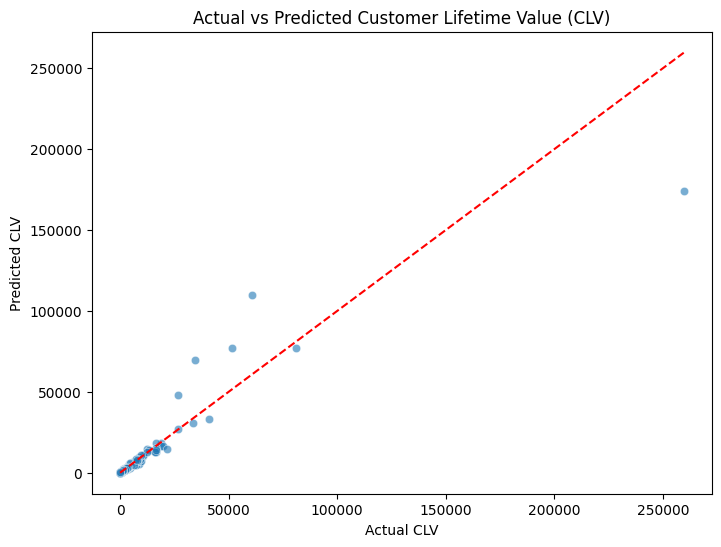

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# y_true and y_pred are original scale CLV (not log scale)
# Make sure y_true and y_pred are numpy arrays or pandas series

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted Customer Lifetime Value (CLV)")
plt.show()
